In [44]:
import sys
from typing import Dict

import matplotlib
import numpy as np
import xarray as xr

climate_indices_home_path = "/home/james/git/climate_indices"
if climate_indices_home_path not in sys.path:
    sys.path.append(climate_indices_home_path)
from climate_indices import compute, indices, utils

%matplotlib inline

In [34]:
netcdf_precip = '/home/james/data/nclimgrid/nclimgrid_lowres_prcp.nc'
netcdf_gamma = '/home/james/data/nclimgrid/nclimgrid_lowres_gamma.nc'

Open the precipitation dataset as an xarray Dataset object.

In [35]:
ds_prcp = xr.open_dataset(netcdf_precip)

Get the precipitation data and reshape the array to have the time dimension as the inner-most axis:

In [36]:
da_prcp = ds_prcp['prcp'].transpose('lat', 'lon', 'time')

In [37]:
initial_year = int(da_prcp['time'][0].dt.year)
calibration_year_initial = 1900
calibration_year_final = 2000
period_times = 12
total_lats = da_prcp.shape[0]
total_lons = da_prcp.shape[1]
fitting_shape = (total_lats, total_lons, period_times)
scales = [1]  # , 2, 3, 6, 9, 12, 24]
periodicity = compute.Periodicity.monthly

Define a function that can be used to compute the gamma fitting parameters for a particular month scale:

In [45]:
def compute_gammas(
    da_precip: xr.DataArray,
    gamma_coords: Dict,
    scale: int,
    calibration_year_initial,
    calibration_year_final,
    periodicity: compute.Periodicity,
) -> (xr.DataArray, xr.DataArray):
    
    initial_year = int(da_precip['time'][0].dt.year)
    if periodicity == compute.Periodicity.monthly:
        period_times = 12
    elif periodicity == compute.Periodicity.daily:
        period_times = 366
    total_lats = da_precip.shape[0]
    total_lons = da_precip.shape[1]
    fitting_shape = (total_lats, total_lons, period_times)
    alphas = np.full(shape=fitting_shape, fill_value=np.NaN)
    betas = np.full(shape=fitting_shape, fill_value=np.NaN)

    # loop over the grid cells and compute the gamma parameters for each
    for lat_index in range(total_lats):
        for lon_index in range(total_lons):

            # get the precipitation values for the lat/lon grid cell
            values = da_precip[lat_index, lon_index]

            # skip over this grid cell if all NaN values
            if (np.ma.is_masked(values) and values.mask.all()) or np.all(np.isnan(values)):
                continue

            # convolve to scale
            scaled_values = \
                compute.scale_values(
                    values,
                    scale=scale,
                    periodicity=periodicity,
                )

            # compute the fitting parameters on the scaled data
            alphas[lat_index, lon_index], betas[lat_index, lon_index] = \
                compute.gamma_parameters(
                    scaled_values,
                    data_start_year=initial_year,
                    calibration_start_year=calibration_year_initial,
                    calibration_end_year=calibration_year_final,
                    periodicity=periodicity,
                )
            
    alpha_attrs = {
        'description': 'shape parameter of the gamma distribution (also referred to as the concentration) ' + \
        f'computed from the {scale}-month scaled precipitation values',
    }
    da_alpha = xr.DataArray(
        data=alphas,
        coords=gamma_coords,
        dims=tuple(gamma_coords.keys()),
        name=f"alpha_{str(scale).zfill(2)}",
        attrs=alpha_attrs,
    )
    beta_attrs = {
        'description': '1 / scale of the distribution (also referred to as the rate) ' + \
        f'computed from the {scale}-month scaled precipitation values',
    }
    da_beta = xr.DataArray(
        data=betas,
        coords=gamma_coords,
        dims=tuple(gamma_coords.keys()),
        name=f"beta_{str(scale).zfill(2)}",
        attrs=beta_attrs,
    )

    return da_alpha, da_beta

Define a function that can be used to compute the SPI for a particular month scale:

In [39]:
def compute_spi_gamma(
        da_precip: xr.DataArray,
        da_alpha: xr.DataArray,
        da_beta: xr.DataArray,
        scale: int,
        periodicity: compute.Periodicity,
) -> xr.DataArray:
    
    initial_year = int(da_precip['time'][0].dt.year)
    total_lats = da_precip.shape[0]
    total_lons = da_precip.shape[1]
    spi = np.full(shape=da_precip.shape, fill_value=np.NaN)

    for lat_index in range(total_lats):
        for lon_index in range(total_lons):

            # get the values for the lat/lon grid cell
            values = da_precip[lat_index, lon_index]

            # skip over this grid cell if all NaN values
            if (np.ma.is_masked(values) and values.mask.all()) or np.all(np.isnan(values)):
                continue

            gamma_parameters = {
                "alphas": da_alpha[lat_index, lon_index],
                "betas": da_beta[lat_index, lon_index],
            }

            # compute the SPI
            spi[lat_index, lon_index] = \
                indices.spi(
                    values,
                    scale=scale,
                    distribution=indices.Distribution.gamma,
                    data_start_year=initial_year,
                    calibration_year_initial=calibration_year_initial,
                    calibration_year_final=calibration_year_final,
                    periodicity=compute.Periodicity.monthly,
                    fitting_params=gamma_parameters,
                )

    # build a DataArray for this scale's SPI
    da_spi = xr.DataArray(
        data=spi,
        coords=da_precip.coords,
        dims=da_precip.dims,
        name=f"spi_gamma_{str(scale).zfill(2)}",
    )
    da_spi.attrs = {
        'description': f'SPI ({scale}-{periodicity} gamma) computed from monthly precipitation ' + \
            f'data for the period {da_precip.time[0]} through {da_precip.time[-1]} using a ' + \
            f'calibration period from {calibration_year_initial} through {calibration_year_final}',
        'valid_min': -3.09,
        'valid_max': 3.09,
        'long_name': f'{scale}-{periodicity} SPI(gamma)',
        'calibration_year_initial': calibration_year_initial,
        'calibration_year_final': calibration_year_final,
    }

    return da_spi

Copy the attributes from the precipitation dataset that will be applicable to the corresponding gamma fitting parameters and SPI datasets:

In [41]:
attrs_to_copy = [
    'Conventions',
    'ncei_template_version',
    'naming_authority',
    'standard_name_vocabulary',
    'institution',
    'geospatial_lat_min',
    'geospatial_lat_max',
    'geospatial_lon_min',
    'geospatial_lon_max',
    'geospatial_lat_units',
    'geospatial_lon_units',
]
global_attrs = {key: value for (key, value) in ds_prcp.attrs.items() if key in attrs_to_copy}

Compute the gamma fitting parameters for all scales and add these into a Dataset that we'll write to NetCDF:

In [50]:
%%time
if periodicity == compute.Periodicity.monthly:
    period_times = 12
    time_coord_name = "month"
elif periodicity == compute.Periodicity.daily:
    period_times = 366
    time_coord_name = "day"
gamma_coords = {"lat": ds_prcp.lat, "lon": ds_prcp.lon, time_coord_name: range(period_times)}
ds_gamma = xr.Dataset(
    coords=gamma_coords,
    attrs=global_attrs,
)
for scale in scales:
    var_name_alpha = f"alpha_{str(scale).zfill(2)}"
    var_name_beta = f"beta_{str(scale).zfill(2)}"
    da_alpha, da_beta = compute_gammas(
        da_prcp,
        gamma_coords,
        scale,
        calibration_year_initial,
        calibration_year_final,
        periodicity,
    )
    ds_gamma[var_name_alpha] = da_alpha
    ds_gamma[var_name_beta] = da_beta
    
ds_gamma.to_netcdf(netcdf_gamma)

CPU times: user 6min 28s, sys: 6.37 s, total: 6min 34s
Wall time: 6min 34s


In [51]:
ds_gamma

<xarray.Dataset>
Dimensions:   (lat: 38, lon: 87, month: 12)
Coordinates:
  * lat       (lat) float32 24.5625 25.229166 25.895834 ... 48.5625 49.229168
  * lon       (lon) float32 -124.6875 -124.020836 ... -68.020836 -67.354164
  * month     (month) int64 0 1 2 3 4 5 6 7 8 9 10 11
Data variables:
    alpha_01  (lat, lon, month) float64 nan nan nan nan nan ... nan nan nan nan
    beta_01   (lat, lon, month) float64 nan nan nan nan nan ... nan nan nan nan
Attributes:
    Conventions:               CF-1.6, ACDD-1.3
    ncei_template_version:     NCEI_NetCDF_Grid_Template_v2.0
    naming_authority:          gov.noaa.ncei
    standard_name_vocabulary:  Standard Name Table v35
    institution:               National Centers for Environmental Information...
    geospatial_lat_min:        24.5625
    geospatial_lat_max:        49.354168
    geospatial_lon_min:        -124.6875
    geospatial_lon_max:        -67.020836
    geospatial_lat_units:      degrees_north
    geospatial_lon_units:      degrees_east

Compute the SPI using the pre-computed gamma fitting parameters for all scales and add these into a SPI(gamma) Dataset that we'll write to NetCDF:

In [53]:
%%time
ds_spi = xr.Dataset(
    coords=ds_prcp.coords,
    attrs=global_attrs,
)
for scale in scales:
    var_name_alpha = f"alpha_{str(scale).zfill(2)}"
    var_name_beta = f"beta_{str(scale).zfill(2)}"
    da_spi = compute_spi_gamma(
        da_prcp,
        ds_gamma[var_name_alpha],
        ds_gamma[var_name_alpha],
        scale,
        periodicity,
    )
    ds_spi[f"spi_gamma_{str(scale).zfill(2)}"] = da_spi
    
netcdf_spi = '/home/james/data/nclimgrid/nclimgrid_lowres_spi_gamma.nc'
ds_spi.to_netcdf(netcdf_spi)

CPU times: user 7min, sys: 6.75 s, total: 7min 7s
Wall time: 7min 8s


In [52]:
ds_spi

<xarray.Dataset>
Dimensions:       (lat: 38, lon: 87, time: 1466)
Coordinates:
  * lat           (lat) float32 24.5625 25.229166 ... 48.5625 49.229168
  * lon           (lon) float32 -124.6875 -124.020836 ... -68.020836 -67.354164
  * time          (time) datetime64[ns] 1895-01-01 1895-02-01 ... 2017-02-01
Data variables:
    spi_gamma_01  (lat, lon, time) float64 nan nan nan nan ... nan nan nan nan
Attributes:
    Conventions:               CF-1.6, ACDD-1.3
    ncei_template_version:     NCEI_NetCDF_Grid_Template_v2.0
    naming_authority:          gov.noaa.ncei
    standard_name_vocabulary:  Standard Name Table v35
    institution:               National Centers for Environmental Information...
    geospatial_lat_min:        24.5625
    geospatial_lat_max:        49.354168
    geospatial_lon_min:        -124.6875
    geospatial_lon_max:        -67.020836
    geospatial_lat_units:      degrees_north
    geospatial_lon_units:      degrees_east

Plot a time step to validate that the SPI values look reasonable:

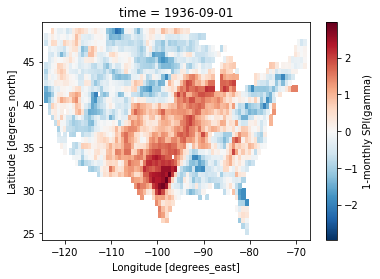

In [53]:
ds_spi[f"spi_gamma_{str(scale).zfill(2)}"].isel(time=500).plot()

Define a function that computes SPI without using pre-computed fitting parameters.

In [54]:
def compute_spi_gamma_without_fittings(
        da_precip: xr.DataArray,
        scale: int,
        periodicity: compute.Periodicity,
) -> xr.DataArray:
    
    initial_year = int(da_precip['time'][0].dt.year)
    total_lats = da_precip.shape[0]
    total_lons = da_precip.shape[1]
    spi = np.full(shape=da_precip.shape, fill_value=np.NaN)

    for lat_index in range(total_lats):
        for lon_index in range(total_lons):

            # get the values for the lat/lon grid cell
            values = da_precip[lat_index, lon_index]

            # skip over this grid cell if all NaN values
            if (np.ma.is_masked(values) and values.mask.all()) or np.all(np.isnan(values)):
                continue

            # compute the SPI
            spi[lat_index, lon_index] = \
                indices.spi(
                    values,
                    scale=scale,
                    distribution=indices.Distribution.gamma,
                    data_start_year=initial_year,
                    calibration_year_initial=calibration_year_initial,
                    calibration_year_final=calibration_year_final,
                    periodicity=compute.Periodicity.monthly,
                )

    # build a DataArray for this scale's SPI
    da_spi = xr.DataArray(
        data=spi,
        coords=da_precip.coords,
        dims=da_precip.dims,
        name=f"spi_gamma_{str(scale).zfill(2)}",
    )
    da_spi.attrs = {
        'description': f'SPI ({scale}-{periodicity} gamma) computed from monthly precipitation ' + \
            f'data for the period {da_precip.time[0]} through {da_precip.time[-1]} using a ' + \
            f'calibration period from {calibration_year_initial} through {calibration_year_final}',
        'valid_min': -3.09,
        'valid_max': 3.09,
        'long_name': f'{scale}-{periodicity} SPI(gamma)',
        'calibration_year_initial': calibration_year_initial,
        'calibration_year_final': calibration_year_final,
    }

    return da_spi

Compute SPI without pre-computed fitting parameters to see if there's a significant time difference.

In [ ]:
%%time
ds_spi_no_fittings = xr.Dataset(
    coords=ds_prcp.coords,
    attrs=global_attrs,
)
for scale in scales:
    da_spi = compute_spi_gamma_without_fittings(
        da_prcp,
        scale,
        periodicity,
    )
    ds_spi_no_fittings[f"spi_gamma_{str(scale).zfill(2)}"] = da_spi
    
netcdf_spi = '/home/james/data/nclimgrid/nclimgrid_lowres_spi_gamma_no_fittings.nc'
ds_spi_no_fittings.to_netcdf(netcdf_spi)